In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import glob
from functools import partial

# My tools
import sys 
path_tools = '/home1/datahome/ljessel/Scripts/'  # path to the toolkit directory
sys.path.append(path_tools)
from map_SAR_variables_toolkit.sar_tools.sar import preprocess_sar, map_sar

# Plotting SAR maps

## 0 - Loading SAR

In [3]:
path = '/home/datawork-cersat-public/cache/project/sarwave/data/products/tests/iw/slc/l2_v1.1/1.4k_operational_v3/'
safe = 'S1A_IW_WAVE_1SDV_20210924T064703_20210924T064731_039820_04B5D5_5245.SAFE'
fns = glob.glob(path+safe+'/*vv*.nc')

Read SAR netCDF and combine the subswaths. 

<div class="alert alert-block alert-warning">
<b>Important note:</b> to use preprocess_sar, the netCDFs should contain footprint, start_date and stop_date attributes.
</div>

In [4]:
varn = ['sar_hs','sar_radar_parameters_flag']  # the wanted variables to keep in the netCDF

partial_func = partial(preprocess_sar, varn=varn)

ds = xr.open_mfdataset(fns,preprocess = partial_func,combine='nested',concat_dim='swath').load()
#ds = xr.open_mfdataset(fns,preprocess = partial_func,combine='nested',concat_dim='swath',group='intraburst').load()    # case with group 

ds

<xarray.Dataset> Size: 11kB
Dimensions:                    (burst: 10, tile_sample: 5, tile_line: 1,
                                fprt: 10, swath: 3, c_sample: 2, c_line: 2)
Coordinates:
  * burst                      (burst) int16 20B 0 1 2 3 4 5 6 7 8 9
  * tile_sample                (tile_sample) int32 20B 0 1 2 3 4
  * tile_line                  (tile_line) int32 4B 0
  * fprt                       (fprt) int64 80B 0 1 2 3 4 5 6 7 8 9
    sample                     (swath, burst, tile_sample, tile_line) float32 600B ...
    line                       (swath, burst, tile_line, tile_sample) float32 600B ...
    longitude                  (swath, burst, tile_line, tile_sample) float32 600B ...
    latitude                   (swath, burst, tile_line, tile_sample) float32 600B ...
    pol                        object 8B 'VV'
    spatial_ref                int32 4B 0
Dimensions without coordinates: swath, c_sample, c_line
Data variables:
    sar_hs                     (swath, burst, tile_line, tile_sample) float64 1kB ...
    sar_radar_parameters_flag  (swath, burst, tile_line, tile_sample) float64 1kB ...
    corner_latitude            (swath, burst, tile_line, tile_sample, c_sample, c_line) float32 2kB ...
    corner_longitude           (swath, burst, tile_line, tile_sample, c_sample, c_line) float32 2kB ...
    land_flag                  (swath, burst, tile_line, tile_sample) float32 600B ...
    footprt                    (swath, fprt) float64 240B -6.437 56.15 ... 56.23
    start                      (swath) datetime64[ns] 24B 2021-09-24T06:47:03...
    stop                       (swath) datetime64[ns] 24B 2021-09-24T06:47:31...
Attributes: (12/27)
    azimuth_time_interval:   0.002055556299999998
    comment:                 denoised digital number, read at full resolution
    coverage:                188km * 98km (line * sample )
    footprint:               POLYGON ((-6.437068135617246 56.14562620365116, ...
    history:                 digital_number: measurement/s1a-iw2-slc-v*-20210...
    ipf:                     3.31
    ...                      ...
    stop_date:               2021-09-24 06:47:31.056296
    swath:                   IW
    tile_overlap_line:       0
    tile_overlap_sample:     0
    tile_width_line:         17700
    tile_width_sample:       17700

<div class="alert alert-block alert-info">
<b>Tip:</b> if the wanted variable as a dimension other than positional dimensions (burst,tile_line,tile_sample), e.g., (burst,tile_line,tile_sample,<b>2tau</b>), you can specify the value of the new dimension to be selected. For instance, 
    
```python
varn = ['macs_Im']
dims_sel = {'lambda_range_max_macs':50,'2tau':0}
partial_func = partial(preprocess_sar, varn=varn,dims_sel = dims_sel)
ds = xr.open_mfdataset(fn,combine    = 'nested',concat_dim = 'swath',preprocess = partial_func,group='intraburst').load()
```

</div>

## 1 - Plotting SAR 

<div class="alert alert-block alert-warning">
<b>Important note:</b> to be able to plot SAR geometries, the netCDFs should contain corner_latitude and corner_longitude variables
</div>

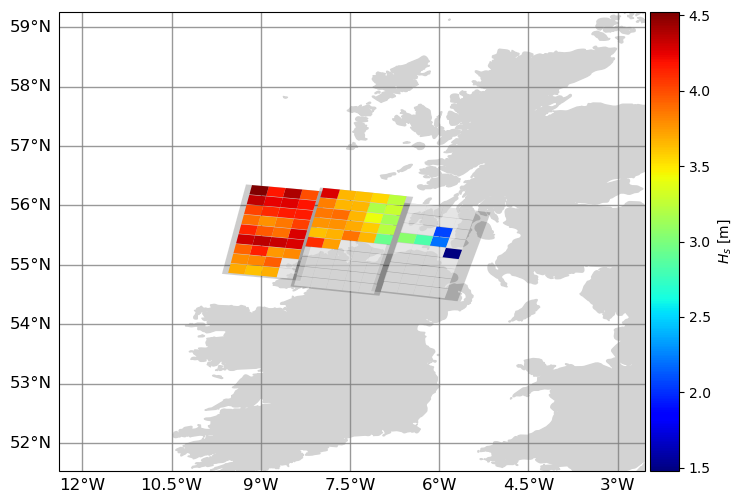

In [5]:
map_sar(ds,'sar_hs',qflag_mask=ds.sar_radar_parameters_flag,land_mask=ds.land_flag,clbl=r'$H_s$ [m]')

## 2 - Adding a map in background

Loading WW3 dataset

In [6]:
path_ww3 = '/home/datawork-WW3/FORECAST/GLOBMULTI/ATNE-10M/FIELD_NC/best_estimate/2021/'
ds_ww3 = xr.open_dataset(path_ww3+'MARC_WW3-ATNE-10M_20210924T06Z.nc').isel(time=0)


Plotting SAR Hs with WW3 Hs in background

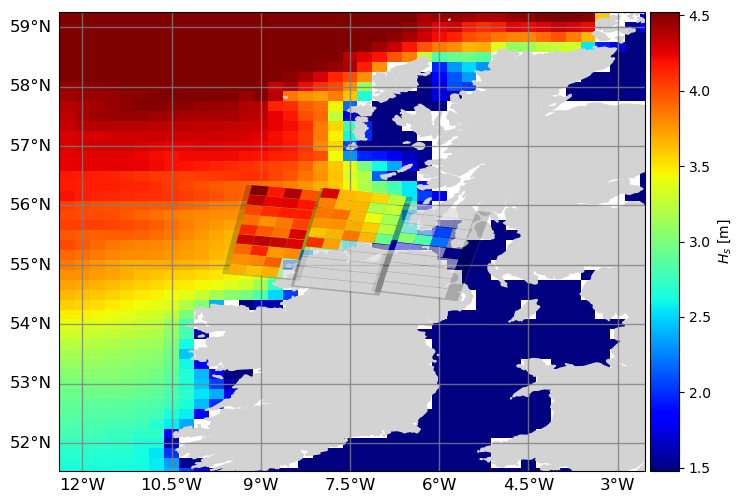

In [7]:
map_sar(ds,'sar_hs',qflag_mask=ds.sar_radar_parameters_flag,land_mask=ds.land_flag,clbl=r'$H_s$ [m]',
           bkgd=(ds_ww3.longitude,ds_ww3.latitude,ds_ww3.hs))

## 3 - Adding a point 

#### specifying the color (lon,lat,color)

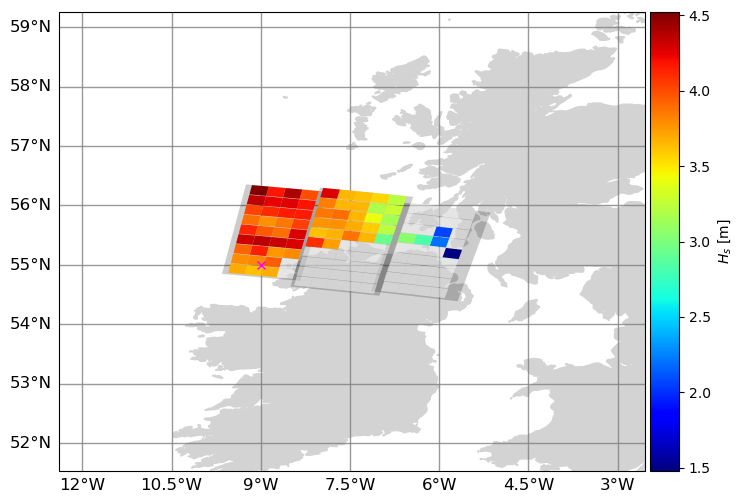

In [8]:
map_sar(ds,'sar_hs',qflag_mask=ds.sar_radar_parameters_flag,land_mask=ds.land_flag,clbl=r'$H_s$ [m]',
        pts=[(-9,55,'magenta')])

#### specifying the value (lon,lat,value)

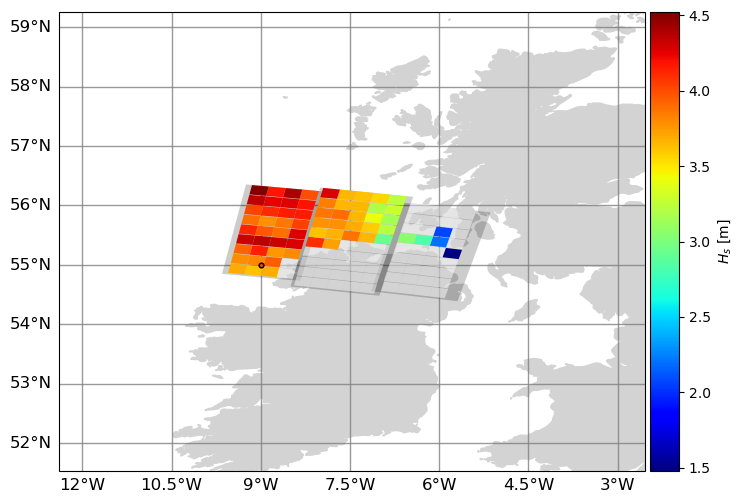

In [9]:
map_sar(ds,'sar_hs',qflag_mask=ds.sar_radar_parameters_flag,land_mask=ds.land_flag,clbl=r'$H_s$ [m]',
        pts=[(-9,55,4)])

## 4 - Adding a trajectory

Create a trajectory (lon,lat,value) and text along trajectory

In [10]:
traj = [np.linspace(-9,-7,30),np.linspace(57,58,30),np.linspace(1.5,4.5,30)]
traj_txt = 'satellite'

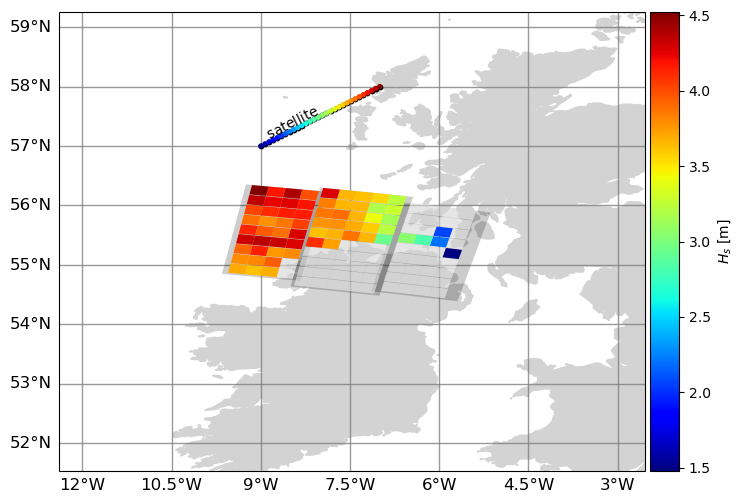

In [11]:
map_sar(ds,'sar_hs',qflag_mask=ds.sar_radar_parameters_flag,land_mask=ds.land_flag,clbl=r'$H_s$ [m]',
        trajs=[traj],txt_along_traj=[traj_txt])